<a href="https://colab.research.google.com/github/datamino/PINNs-Research/blob/main/pde_code_for_burger_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import warnings


warnings.filterwarnings("ignore")
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


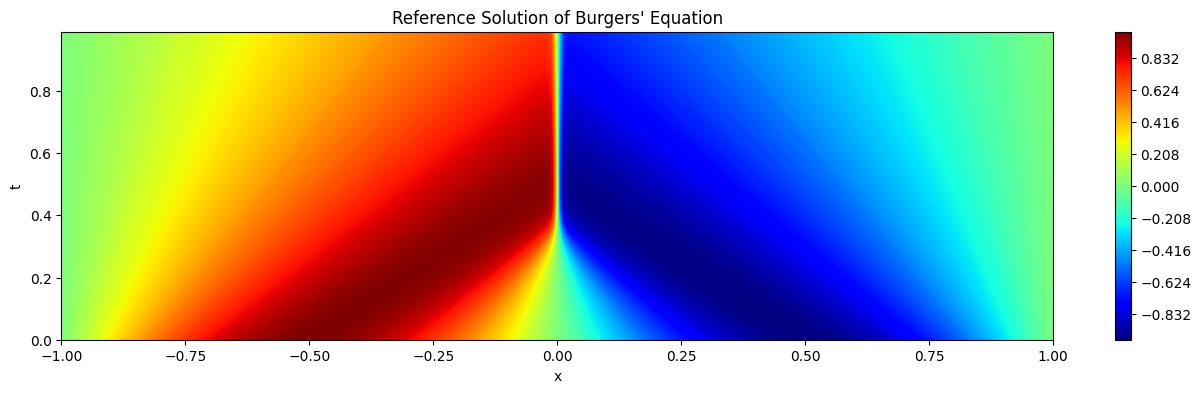

In [218]:
# Load dataset
mat_data = scipy.io.loadmat('/content/burgers_shock.mat')
x_true = mat_data['x']
t_true = mat_data['t']
usol = mat_data['usol'].T
x_true, t_true = np.meshgrid(x_true, t_true)

# Plot reference solution
plt.figure(figsize=(16, 4))
plt.contourf(x_true, t_true, usol, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Reference Solution of Burgers\' Equation')
plt.savefig('reference_solution.png', dpi=300)
plt.show()

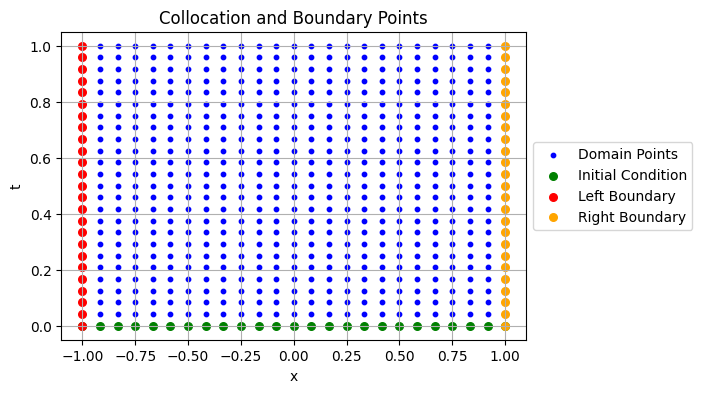

In [206]:
# Collocation data
x_values = torch.linspace(-1, 1, 25).view(-1, 1)
t_values = torch.linspace(0, 1, 25).view(-1, 1)
x_collocation, t_collocation = torch.meshgrid(x_values.squeeze(), t_values.squeeze(), indexing='xy')
x_collocation = x_collocation.reshape(-1, 1)
t_collocation = t_collocation.reshape(-1, 1)

# Initial and boundary points
x_boundary_left = torch.full_like(t_values, -1)
x_boundary_right = torch.full_like(t_values, 1)
t_boundary_points = t_values
t_initial_condition = torch.zeros_like(x_values)
x_initial_condition = x_values

# Visualize domain and boundary points
plt.figure(figsize=(6, 4))
plt.scatter(x_collocation.numpy(), t_collocation.numpy(), label='Domain Points', color='blue', s=10)
plt.scatter(x_initial_condition.numpy(), t_initial_condition.numpy(), label='Initial Condition', color='green', s=30)
plt.scatter(x_boundary_left.numpy(), t_boundary_points.numpy(), label='Left Boundary', color='red', s=30)
plt.scatter(x_boundary_right.numpy(), t_boundary_points.numpy(), label='Right Boundary', color='orange', s=30)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Collocation and Boundary Points')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()

In [207]:
# Define PINN
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = nn.Sequential(
            nn.Linear(2, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.hidden(inputs)

In [208]:
# PDE residual
def pde_residual(x, t, model, nu=0.01):
    x.requires_grad = True
    t.requires_grad = True
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u), create_graph=True)[0]
    return u_t + u * u_x - nu / np.pi * u_xx

# Initial and boundary conditions
def initial_condition(x):
    return -torch.sin(np.pi * x)

def boundary_condition(x, t):
    return torch.zeros_like(t)

In [209]:
# Training data
x = torch.linspace(-1, 1, 200).view(-1, 1)
t = torch.linspace(0, 1, 100).view(-1, 1)
x_train, t_train = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='xy')
x_train = x_train.reshape(-1, 1)
t_train = t_train.reshape(-1, 1)

# Model, optimizer
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Move data to device
x = x.to(device)
t = t.to(device)
x_train = x_train.to(device)
t_train = t_train.to(device)

Epoch [500/10000], Loss: 0.154072
Epoch [1000/10000], Loss: 0.106299
Epoch [1500/10000], Loss: 0.088200
Epoch [2000/10000], Loss: 0.079330
Epoch [2500/10000], Loss: 0.059415
Epoch [3000/10000], Loss: 0.021793
Epoch [3500/10000], Loss: 0.010173
Epoch [4000/10000], Loss: 0.006740
Epoch [4500/10000], Loss: 0.005205
Epoch [5000/10000], Loss: 0.004193
Epoch [5500/10000], Loss: 0.003453
Epoch [6000/10000], Loss: 0.002908
Epoch [6500/10000], Loss: 0.002443
Epoch [7000/10000], Loss: 0.002103
Epoch [7500/10000], Loss: 0.001841
Epoch [8000/10000], Loss: 0.001640
Epoch [8500/10000], Loss: 0.001481
Epoch [9000/10000], Loss: 0.001339
Epoch [9500/10000], Loss: 0.001219
Epoch [10000/10000], Loss: 0.001123


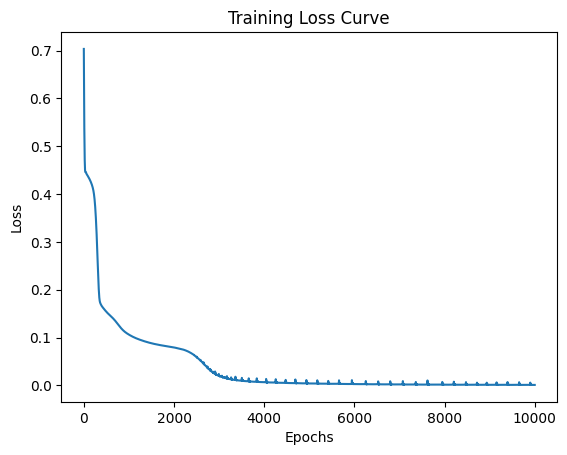

In [210]:
# List to store the loss at each epoch
losses = []

num_epochs = 10000
for epoch in range(num_epochs):
    model.train()

    u_pred = model(x, torch.zeros_like(x))
    u_true = initial_condition(x)
    loss_ic = torch.mean((u_pred - u_true) ** 2)

    u_pred_left = model(torch.full_like(t, -1), t)
    u_pred_right = model(torch.full_like(t, 1), t)
    loss_bc = torch.mean((u_pred_left - boundary_condition(None, t)) ** 2) + \
              torch.mean((u_pred_right - boundary_condition(None, t)) ** 2)

    residual = pde_residual(x_train, t_train, model)
    loss_pde = torch.mean(residual ** 2)

    loss = loss_ic + loss_bc + loss_pde

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the loss at this epoch
    losses.append(loss.item())

    if (epoch + 1) % 500 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}')

# After training, plot the loss curve


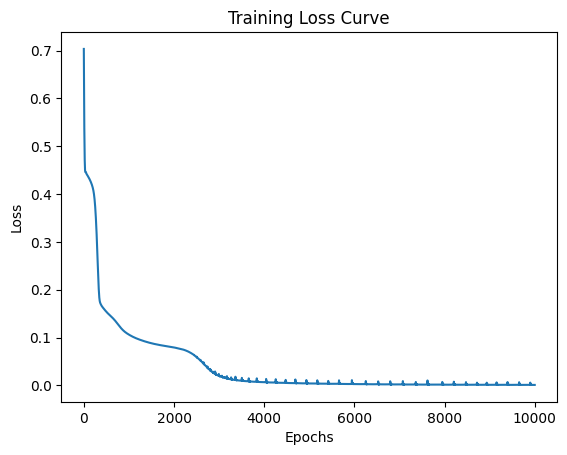

In [217]:
plt.plot(range(num_epochs), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.savefig('loss_curve.png', dpi=300)
plt.show()

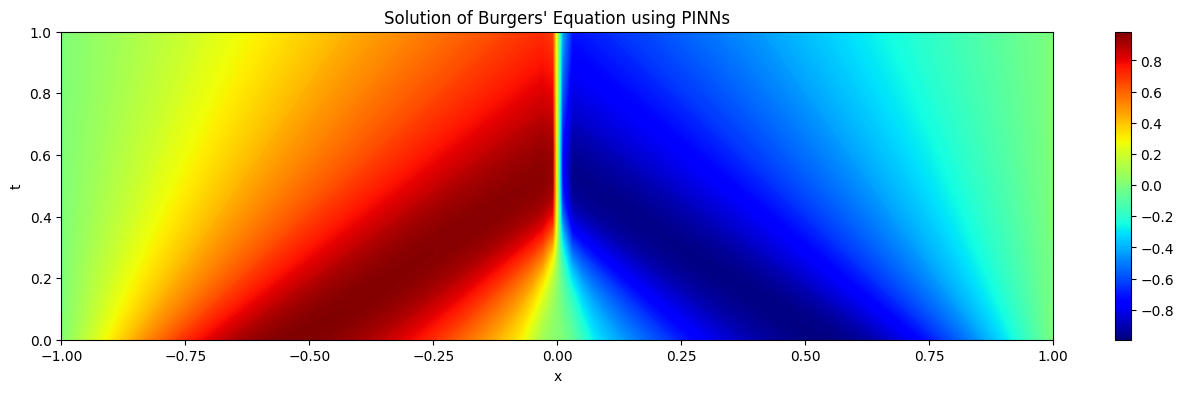

In [216]:
# Evaluation
x_test = torch.linspace(-1, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='xy')
x_test_flat = x_test.reshape(-1, 1).to(device)
t_test_flat = t_test.reshape(-1, 1).to(device)

model.eval()
with torch.no_grad():
    u_pred = model(x_test_flat, t_test_flat).cpu().numpy()

# Reshape
x_test = x_test.numpy()
t_test = t_test.numpy()
u_pred = u_pred.reshape(100, 100)

# Plot predictions
plt.figure(figsize=(16, 4))
plt.contourf(x_test, t_test, u_pred, levels=250, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title("Solution of Burgers' Equation using PINNs")
plt.savefig('Pinns.png', dpi=300)
plt.show()


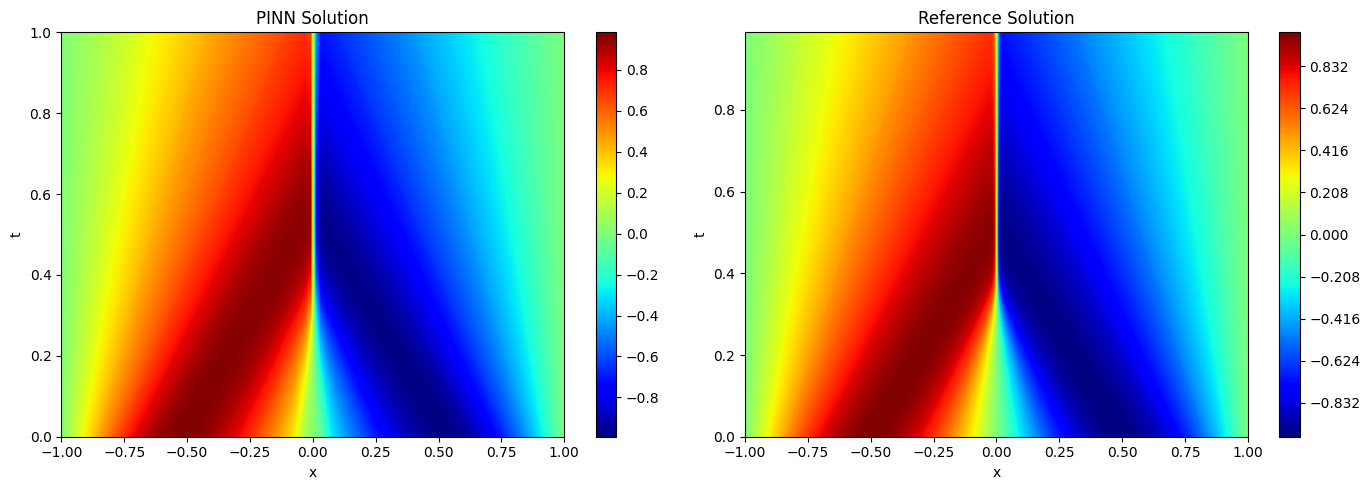

In [215]:
# Compare reference vs predicted
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
c1 = ax1.contourf(x_test, t_test, u_pred, levels=250, cmap='jet')
fig.colorbar(c1, ax=ax1)
ax1.set_title('PINN Solution')
ax1.set_xlabel('x')
ax1.set_ylabel('t')

c2 = ax2.contourf(x_true, t_true, usol, levels=250, cmap='jet')
fig.colorbar(c2, ax=ax2)
ax2.set_title('Reference Solution')
ax2.set_xlabel('x')
ax2.set_ylabel('t')

plt.tight_layout()
plt.savefig('pinns_vs_refrence.png', dpi=300)
plt.show()

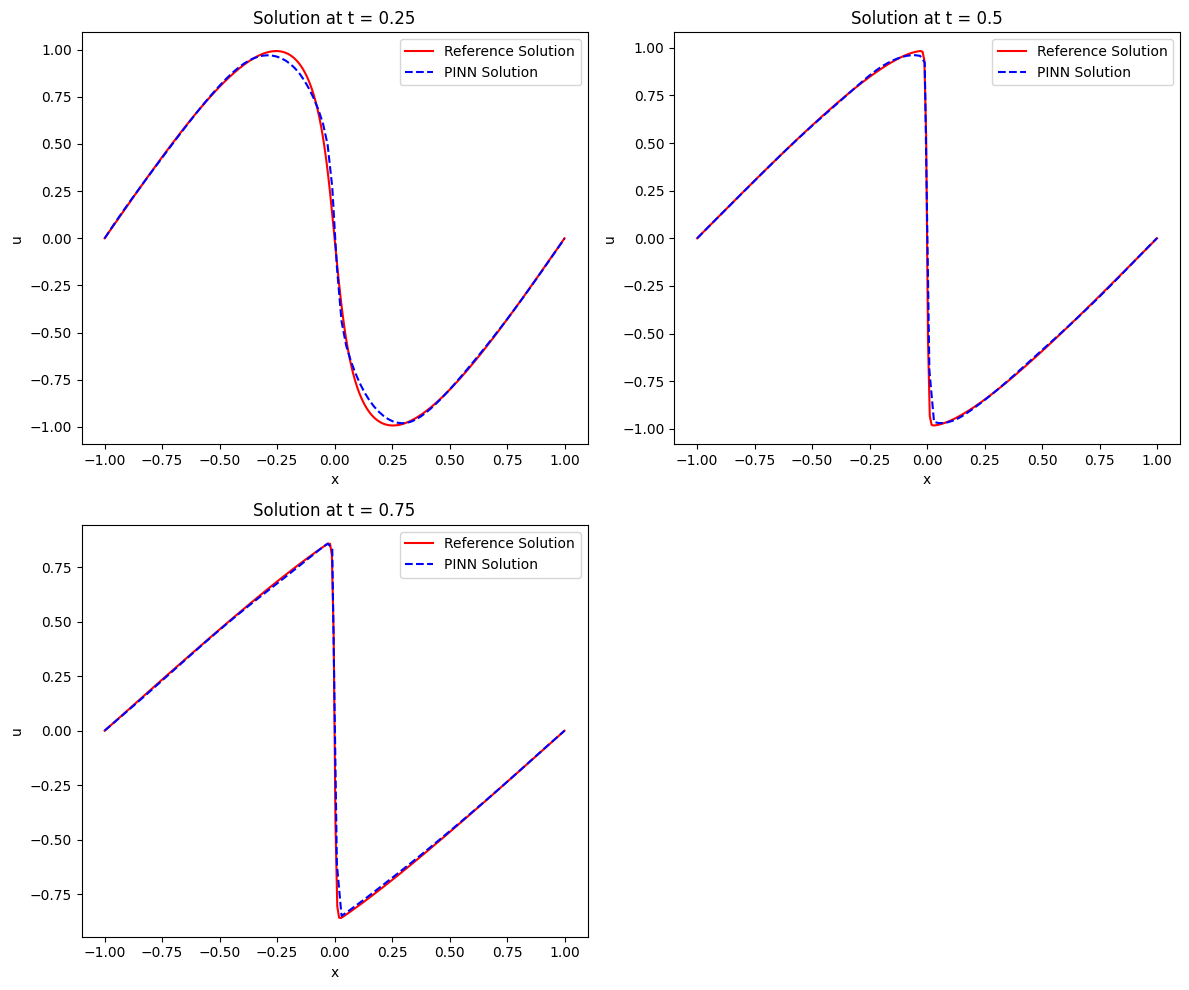

In [214]:
# Sample time instances to visualize
time_slices = [0.25, 0.50, 0.75]

# Determine subplot layout
num_plots = len(time_slices)
cols = 2
rows = (num_plots // cols) + (num_plots % cols)

# Create subplots
fig, axs = plt.subplots(rows, cols, figsize=(12, 5 * rows))
axs = axs.flatten()

# Convert t to numpy if it's a torch tensor
if torch.is_tensor(t):
    t_cpu = t.detach().cpu().numpy()
else:
    t_cpu = t

# Loop over each time slice
for i, t_val in enumerate(time_slices):
    # Find index in reference solution closest to current t_val
    idx_ref = np.argmin(np.abs(t_cpu[:, 0] - t_val))
    u_ref_slice = usol[idx_ref, :]

    # Create x and t slices for inference
    x_slice = np.linspace(-1, 1, 100).reshape(-1, 1)
    t_slice = t_val * np.ones_like(x_slice)

    # Convert to tensors and move to GPU
    x_tensor = torch.tensor(x_slice, dtype=torch.float32).to('cuda')
    t_tensor = torch.tensor(t_slice, dtype=torch.float32).to('cuda')

    # Predict using PINN model
    model.eval()
    with torch.no_grad():
        u_pinn_slice = model(x_tensor, t_tensor).cpu().numpy()

    # Plotting
    x_ref = np.linspace(-1, 1, len(u_ref_slice))  # match length of u_ref_slice
    axs[i].plot(x_ref, u_ref_slice, 'r-', label='Reference Solution')
    axs[i].plot(x_slice, u_pinn_slice, 'b--', label='PINN Solution')
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('u')
    axs[i].set_title(f'Solution at t = {t_val}')
    axs[i].legend()

# Remove empty plots if any
for j in range(num_plots, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout
plt.tight_layout()
plt.savefig('Analytical_vs_pinns.png', dpi=300)
plt.show()